<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_stl10_mse_HeNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [3]:
img_ht = 48
img_wd = 48

input_size = (img_ht,img_wd,3)
latent_dim = 512
batch_size = 512

#initializer = initializers.GlorotNormal()
initializer = initializers.HeNormal(seed=123)

In [12]:
ds = tfds.load('stl10', split='test')

In [13]:
ds2 = tfds.load('stl10', split='train')

In [14]:
ds3 = tfds.load('stl10', split='unlabelled[:3%]')

In [15]:
ds_to_np = list(ds.as_numpy_iterator())+list(ds2.as_numpy_iterator()) +list(ds3.as_numpy_iterator())

In [16]:
print(set(tuple(x.keys()) for x in ds_to_np))                # we converted the list of keys into a tuple since we wanted to use set() for duplicate removal
                                                             # set() only works on hashable objects like strings, numbers, and tuples,
                                                             # and not on mutables like dicts and strings

print(set(x['label'] for x in ds_to_np))
print(set(type(x['image']) for x in ds_to_np))
print(set(x['image'].shape for x in ds_to_np))
print(len(ds_to_np))

{('image', 'label')}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
{<class 'numpy.ndarray'>}
{(96, 96, 3)}
16000


ds_to_np is a list of dictionaries where the key:value pairs are the 'image':img_ndarray, 'label'=-1. We want to collect all these arrays and form a tensor/array. There are 100k images. We'll use 50k of them in the training set, 25k for validation, and 25k for the test set.

In [17]:
random.seed(100)
random.shuffle(ds_to_np)                                    # random permutation in place
img_train = np.array([x['image'] for x in ds_to_np[:15000]])
img_valid = np.array([x['image'] for x in ds_to_np[15000:]])
#img_test = np.array([x['image'] for x in ds_to_np[13000:]])

img_train = img_train/255
img_valid = img_valid/255
#img_test = img_test/255

In [9]:
print(img_train.shape)

(15000, 96, 96, 3)


In [18]:
img_train = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_train)
print(img_train.shape)

img_valid = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_valid)
print(img_valid.shape)

#img_test = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_test)
#print(img_valid.shape)

(15000, 48, 48, 3)
(1000, 48, 48, 3)


In [19]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)


x = layers.Conv2D(512, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid")(x)

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 re_lu_112 (ReLU)            (None, 46, 46, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 re_lu_113 (ReLU)            (None, 44, 44, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                           

In [20]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(4*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,512))(x)

x = layers.Conv2DTranspose(512, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 512)]             0         
                                                                 
 dense_9 (Dense)             (None, 2048)              1050624   
                                                                 
 re_lu_125 (ReLU)            (None, 2048)              0         
                                                                 
 reshape_6 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_86 (Conv2  (None, 2, 2, 512)         262656    
 DTranspose)                                                     
                                                                 
 re_lu_126 (ReLU)            (None, 2, 2, 512)         0         
                                                           

In [21]:
decoder_out = decoder(encoder(encoder_input))
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 encoder (Functional)        (None, 512)               6916160   
                                                                 
 decoder (Functional)        (None, 48, 48, 3)         5723203   
                                                                 
Total params: 12639363 (48.22 MB)
Trainable params: 12639363 (48.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
K.clear_session()

In [25]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.98)
optim = keras.optimizers.Adam(learning_rate = 0.001)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss='mse')

In [26]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
30/30 [==============================] - 24s 583ms/step - loss: 0.0490 - val_loss: 0.0340
Epoch 2/10
30/30 [==============================] - 17s 580ms/step - loss: 0.0313 - val_loss: 0.0298
Epoch 3/10
30/30 [==============================] - 17s 578ms/step - loss: 0.0285 - val_loss: 0.0282
Epoch 4/10
30/30 [==============================] - 17s 554ms/step - loss: 0.0275 - val_loss: 0.0270
Epoch 5/10
30/30 [==============================] - 17s 552ms/step - loss: 0.0279 - val_loss: 0.0271
Epoch 6/10
30/30 [==============================] - 17s 560ms/step - loss: 0.0262 - val_loss: 0.0263
Epoch 7/10
30/30 [==============================] - 17s 567ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 8/10
30/30 [==============================] - 17s 567ms/step - loss: 0.0254 - val_loss: 0.0253
Epoch 9/10
30/30 [==============================] - 17s 562ms/step - loss: 0.0256 - val_loss: 0.0250
Epoch 10/10
30/30 [==============================] - 17s 560ms/step - loss: 0.0248 - val_lo

In [28]:
optim = keras.optimizers.Adam(learning_rate = 0.00075)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss='mse')
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
30/30 [==============================] - 36s 604ms/step - loss: 0.0391 - val_loss: 0.0295
Epoch 2/10
30/30 [==============================] - 17s 582ms/step - loss: 0.0270 - val_loss: 0.0257
Epoch 3/10
30/30 [==============================] - 17s 563ms/step - loss: 0.0250 - val_loss: 0.0248
Epoch 4/10
30/30 [==============================] - 17s 555ms/step - loss: 0.0244 - val_loss: 0.0245
Epoch 5/10
30/30 [==============================] - 17s 558ms/step - loss: 0.0242 - val_loss: 0.0245
Epoch 6/10
30/30 [==============================] - 17s 571ms/step - loss: 0.0239 - val_loss: 0.0241
Epoch 7/10
30/30 [==============================] - 17s 568ms/step - loss: 0.0241 - val_loss: 0.0240
Epoch 8/10
30/30 [==============================] - 17s 568ms/step - loss: 0.0236 - val_loss: 0.0241
Epoch 9/10
30/30 [==============================] - 17s 574ms/step - loss: 0.0237 - val_loss: 0.0254
Epoch 10/10
30/30 [==============================] - 17s 564ms/step - loss: 0.0241 - val_lo

In [29]:
optim = keras.optimizers.Adam(learning_rate = 0.0005)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss='mse')
history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
30/30 [==============================] - 24s 586ms/step - loss: 0.0324 - val_loss: 0.0263
Epoch 2/10
30/30 [==============================] - 17s 582ms/step - loss: 0.0249 - val_loss: 0.0244
Epoch 3/10
30/30 [==============================] - 17s 570ms/step - loss: 0.0237 - val_loss: 0.0239
Epoch 4/10
30/30 [==============================] - 17s 560ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 5/10
30/30 [==============================] - 17s 561ms/step - loss: 0.0230 - val_loss: 0.0235
Epoch 6/10
30/30 [==============================] - 17s 564ms/step - loss: 0.0228 - val_loss: 0.0234
Epoch 7/10
30/30 [==============================] - 17s 568ms/step - loss: 0.0227 - val_loss: 0.0235
Epoch 8/10
30/30 [==============================] - 17s 566ms/step - loss: 0.0225 - val_loss: 0.0236
Epoch 9/10
30/30 [==============================] - 17s 563ms/step - loss: 0.0224 - val_loss: 0.0232
Epoch 10/10
30/30 [==============================] - 17s 567ms/step - loss: 0.0222 - val_lo

In [31]:
optim = keras.optimizers.Adam(learning_rate = 0.00001)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss='mse')
history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, steps_per_epoch=None)

Epoch 1/20
30/30 [==============================] - 25s 593ms/step - loss: 0.0217 - val_loss: 0.0229
Epoch 2/20
30/30 [==============================] - 18s 589ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 3/20
30/30 [==============================] - 17s 566ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 4/20
30/30 [==============================] - 17s 556ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 5/20
30/30 [==============================] - 17s 566ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 6/20
30/30 [==============================] - 17s 575ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 7/20
30/30 [==============================] - 17s 567ms/step - loss: 0.0216 - val_loss: 0.0228
Epoch 8/20
30/30 [==============================] - 17s 567ms/step - loss: 0.0215 - val_loss: 0.0228
Epoch 9/20
30/30 [==============================] - 17s 568ms/step - loss: 0.0215 - val_loss: 0.0228
Epoch 10/20
30/30 [==============================] - 17s 568ms/step - loss: 0.0215 - val_lo

In [32]:
optim = keras.optimizers.Adam(learning_rate = 0.00002)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss='mse')
history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
30/30 [==============================] - 25s 582ms/step - loss: 0.0214 - val_loss: 0.0227
Epoch 2/10
30/30 [==============================] - 18s 584ms/step - loss: 0.0213 - val_loss: 0.0227
Epoch 3/10
30/30 [==============================] - 17s 571ms/step - loss: 0.0213 - val_loss: 0.0227
Epoch 4/10
30/30 [==============================] - 17s 559ms/step - loss: 0.0213 - val_loss: 0.0227
Epoch 5/10
30/30 [==============================] - 17s 566ms/step - loss: 0.0213 - val_loss: 0.0227
Epoch 6/10
30/30 [==============================] - 17s 563ms/step - loss: 0.0213 - val_loss: 0.0227
Epoch 7/10
30/30 [==============================] - 17s 568ms/step - loss: 0.0212 - val_loss: 0.0227
Epoch 8/10
30/30 [==============================] - 17s 578ms/step - loss: 0.0212 - val_loss: 0.0227
Epoch 9/10
30/30 [==============================] - 17s 576ms/step - loss: 0.0212 - val_loss: 0.0226
Epoch 10/10
30/30 [==============================] - 17s 565ms/step - loss: 0.0212 - val_lo

In [33]:
optim = keras.optimizers.Adam(learning_rate = 0.00003)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss='mse')
history6 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
30/30 [==============================] - 24s 580ms/step - loss: 0.0212 - val_loss: 0.0226
Epoch 2/10
30/30 [==============================] - 18s 594ms/step - loss: 0.0211 - val_loss: 0.0226
Epoch 3/10
30/30 [==============================] - 17s 569ms/step - loss: 0.0211 - val_loss: 0.0226
Epoch 4/10
30/30 [==============================] - 17s 558ms/step - loss: 0.0211 - val_loss: 0.0226
Epoch 5/10
30/30 [==============================] - 17s 558ms/step - loss: 0.0210 - val_loss: 0.0226
Epoch 6/10
30/30 [==============================] - 17s 565ms/step - loss: 0.0210 - val_loss: 0.0225
Epoch 7/10
30/30 [==============================] - 17s 569ms/step - loss: 0.0210 - val_loss: 0.0225
Epoch 8/10
30/30 [==============================] - 17s 567ms/step - loss: 0.0210 - val_loss: 0.0225
Epoch 9/10
30/30 [==============================] - 17s 565ms/step - loss: 0.0209 - val_loss: 0.0225
Epoch 10/10
30/30 [==============================] - 17s 575ms/step - loss: 0.0209 - val_lo

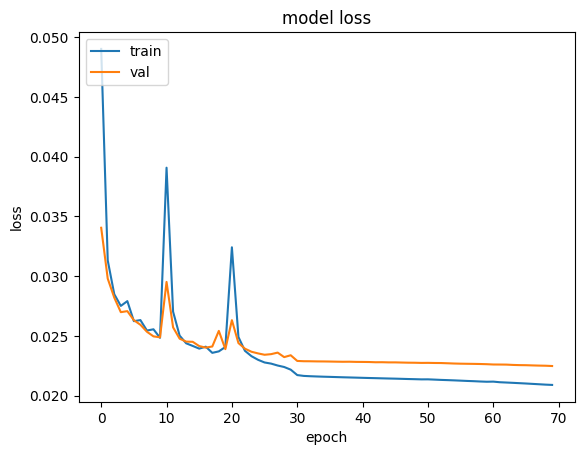

In [34]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss']+history6.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss']+history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(18,8))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((64,64,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

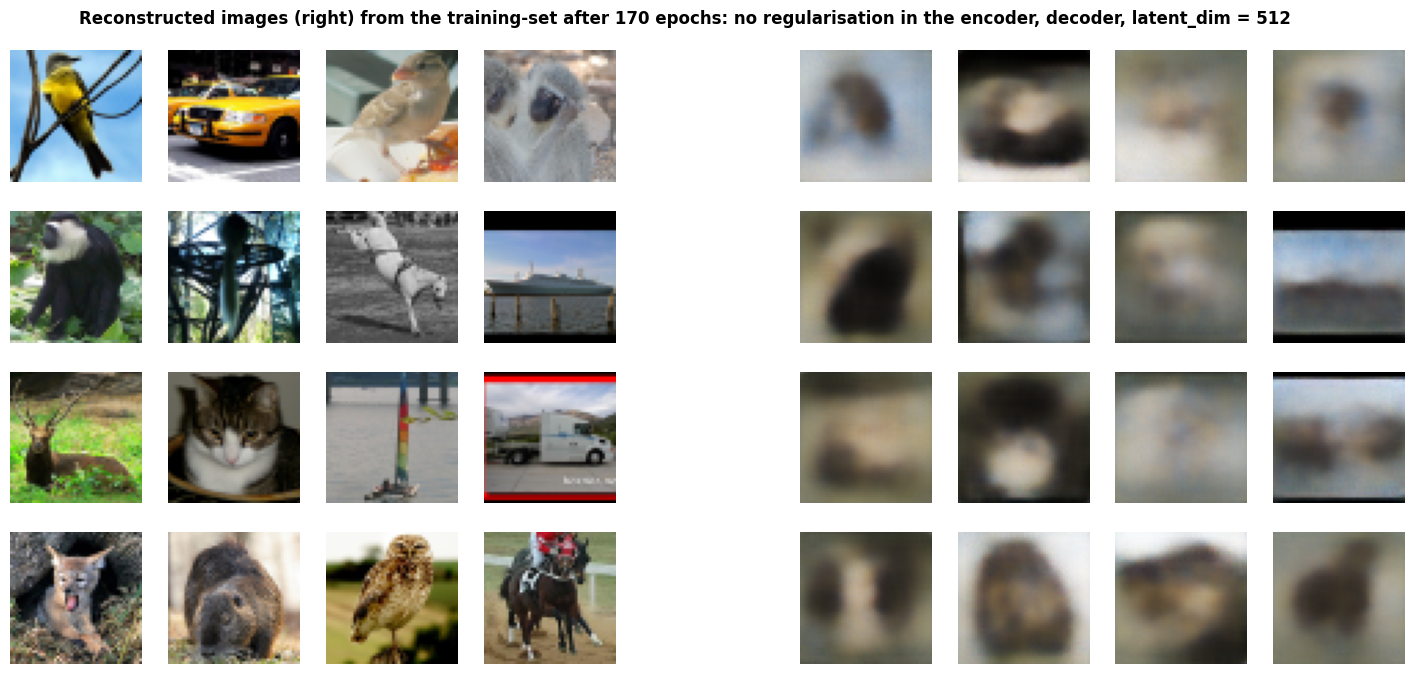

In [36]:
plot_reconstruction(img_train, 'training', 100, 170)